# Solving Single Decisions

## The "Party Problem" example

JMA 11 Jan 2024

In [1]:
# Imports from the python standard library
import math, re, os, sys
from pathlib import Path
import itertools            # to flatten lists

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd

import networkx as nx

# for extract_net
# from ID_operations import * 
from potential_operations import *
import BN

# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
# from bokeh.plotting import figure, show
# from bokeh.models import ColumnDataSource, VBar, Span
# from bokeh.io import output_notebook
# output_notebook()

NETWORK_FILE = 'PartyProblem_asym.xdsl' # 'PartyProblem_asym.xdsl'  # 

In [2]:
# BN structure is contained under the node branch
parsed = BN.extract_net(NETWORK_FILE)
nodes, extensions = parsed
# tags tell the node type. 
[( k.get('id'), k.tag) for k in nodes]

found nodes


[('Party_location', 'decision'),
 ('Weather', 'cpt'),
 ('Preferences', 'utility'),
 ('Utility', 'maux'),
 ('Adjustor', 'cpt'),
 ('Detector', 'cpt')]

## Bayes networks object

### Include state and variable names to tensor dimensions

### Add graph structure

It contains 

- the parse of the network as a dictionary with node names as keys
- The graph object showing network structure
- Node Potential objects for computation. 


In [3]:
# CPT contents are stored in row major order (first row, second row, ...)
# Parents are the first matrix dimension -- matrix is Row Markov
pp_net = BN.reap(parsed)
pp_net.pr_nodes()


Edges:  [('Weather', 'Preferences'), ('Party_location', 'Preferences'), ('Weather', 'Detector'), ('Adjustor', 'Detector')] 

>>> Party_location <<<
Party_location: decision
	states: ['Outdoors', 'Porch', 'Indoors']
	named tensor: [('Party_location', 'm')], [3]
       [1, 1, 1]

>>> Weather <<<
Weather: cpt
	states: ['Sunshine', 'Rain']
	named tensor: [('Weather', 'm')], [2]
       [0.4000, 0.6000]

>>> Preferences <<<
Preferences: utility
	states: ['utility']
	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]

>>> Adjustor <<<
Adjustor: cpt
	states: ['absent', 'present']
	named tensor: [('Adjustor', 'm')], [2]
       [0.1000, 0.9000]

>>> Detector <<<
Detector: cpt
	states: ['SaySun', 'SayRain']
	named tensor: [('Weather', 'c'), ('Adjustor', 'c'), ('Detector', 'm')], [2, 2, 2]
       [[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[

reap: Party_location, decision
reap: Weather, cpt
reap: Preferences, utility
reap: Utility, maux
Unsupported node type: maux
reap: Adjustor, cpt
reap: Detector, cpt


In [4]:
pp_net.pr_influences()



Node	{ancestors}
	{descendants}

Weather :  set() 
	 {'Detector', 'Preferences'} 

Preferences :  {'Party_location', 'Weather'} 
	 set() 

Party_location :  set() 
	 {'Preferences'} 

Detector :  {'Adjustor', 'Weather'} 
	 set() 

Adjustor :  set() 
	 {'Detector'} 



### Extract matrices as tensors.  _List all tensors_

In [5]:
pp_net.pr_named_tensors()

Weather 
	 OrderedDict({'Weather': 'm'})
	tensor([0.4000, 0.6000]) 

Preferences 
	 OrderedDict({'Weather': 'c', 'Party_location': 'c', 'Preferences': 'm'})
	tensor([[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]) 

Adjustor 
	 OrderedDict({'Adjustor': 'm'})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Weather': 'c', 'Adjustor': 'c', 'Detector': 'm'})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



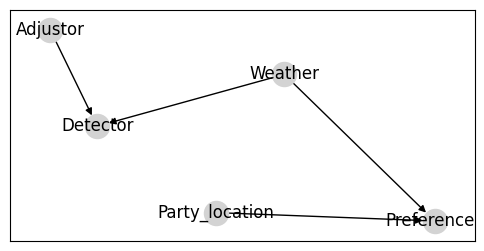

In [6]:
# TODO move to BN class

pp_net.pr_network()

In [7]:
## pretty print one of the variables
pp_net.pr_one_dim_table( 'Weather', tablefmt= '.4f', headers= ['State', 'Value'])



 *** Weather ***
State       Value
--------  -------
Sunshine      0.4
Rain          0.6


### Utilities

In [8]:
# Utility matrix, as a Potential
outcome_potential = pp_net.get_potential('Preferences')
outcome_potential.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[100.],
         [ 90.],
         [ 40.]],

        [[  0.],
         [ 20.],
         [ 50.]]]


In [9]:
utility_p = named_tensor_apply(outcome_potential, delta_utility, exponand = 0.5, normalize = 50)
utility_p.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[1.0000],
         [0.9504],
         [0.5675]],

        [[0.0000],
         [0.3229],
         [0.6667]]]


In [10]:
# Check that the inverse function returns the outcome values
named_tensor_apply(utility_p, delta_inverse_utility, exponand = 0.5, normalize = 50)

OrderedDict({'Weather': 'c', 'Party_location': 'c', 'Preferences': 'm'})
	tensor([[[100.],
         [ 90.],
         [ 40.]],

        [[ -0.],
         [ 20.],
         [ 50.]]])

## Solving the party problem

_Using just potential operations (not Node removal)

To determine the optimal policy --

* join Adjustor and Detector CPTs, marginalize out Adjustor
* join Detector and Weather CPTs, marginalize out Detector 
* join Weather with Utility (Decision has unit values for all options)
* marginalize out unobserved Weather 
* Maximize over options
* (marginalize out Utility to get decision lottery)

### First solution - only prior, no observation 

In [11]:
# Remove Adjustor
detector_p = pp_net.get_potential('Detector')
adjustor_p = pp_net.get_potential('Adjustor')
detector_marginal = absorb_parent(adjustor_p, detector_p)
detector_marginal.pr_potential()

	named tensor: [('Weather', 'c'), ('Detector', 'm')], [2, 2]
       [[0.8340, 0.1660],
        [0.4080, 0.5920]]


In [12]:
# Remove Detector
# Note this just returns the Weather prior, as it should. 
weather_p = pp_net.get_potential('Weather')
wd_joint = join(weather_p, detector_marginal)  #TODO wrap these in a reverse arc & remove function
weather_marginal = marginalize(wd_joint, 'Detector')
weather_marginal.pr_potential()

	named tensor: [('Weather', 'm')], [2]
       [0.4000, 0.6000]


### Compute the expected outcome value

The expected value __before__ applying the utility function

In [13]:
# Compare with Howard & Abbas p. 208 - agrees! 
# TODO wrap this in a high level function
squeezed_outcome = drop_singleton_dimension(outcome_potential)
joined_outcome = join(weather_marginal, squeezed_outcome)
expected_outcome = marginalize(joined_outcome, 'Weather')
print('Alternatives:',pp_net.get_node('Party_location').get_states())
expected_outcome.pr_potential()


Alternatives: ['Outdoors', 'Porch', 'Indoors']
	named tensor: [('Party_location', 'c')], [3]
       [40., 48., 46.]


In [ ]:
# Find the name of the marginal variable (marginal is the default)
outcome_potential.get_var_by_type()

['Preferences']

In [15]:
# Must we drop the singleton dim first from the utility?
utility_p.pr_potential()

	named tensor: [('Weather', 'c'), ('Party_location', 'c'), ('Preferences', 'm')], [2, 3, 1]
       [[[1.0000],
         [0.9504],
         [0.5675]],

        [[0.0000],
         [0.3229],
         [0.6667]]]


In [16]:
# Utility expected value over decision alternatives
# Compare with Howard & Abbas p. 181 - agrees! 
# TODO wrap this in a high level function
squeezed_utility = drop_singleton_dimension(utility_p)
joined_utility = join(weather_marginal, squeezed_utility)
expected_utility = marginalize(joined_utility, 'Weather')
print('Alternatives:',pp_net.get_node('Party_location').get_states())
expected_utility.pr_potential()



Alternatives: ['Outdoors', 'Porch', 'Indoors']
	named tensor: [('Party_location', 'c')], [3]
       [0.4000, 0.5739, 0.6270]


### Party problem 2; when Weather is observed

To solve this --

* Add an informational "cause" to the decision node by
* Using the Weather marginal as a conditioning for Party location

_alternately add the conditioning arc in the xdsl file instead of programmatically modifying it._

In [17]:
# P( Weather | Detector) - column markov
# See p 270 Figure 13.6
# Modify the decision node, and add the weather dimension to its Potential. 
decn_node = pp_net.get_node('Party_location')
decn_p = decn_node.get_potential()
decn_dims = decn_p.get_named_dims()
# Prefix the weather 'm' dim OrderedDict has a function for this
decn_dims['Weather'] = 'm'
decn_dims.move_to_end('Weather', last=False)
# Prefix a dimension to the decision cpt table
# Use the global weather potential
conditioning_size = weather_p.get_dim_sizes()[-1]    # Marginal dim is last
extended_shape = list(decn_p.get_dim_sizes())
extended_shape.insert(0, conditioning_size)
cpt = torch.ones(extended_shape)
extended_decn_p = Potential(cpt, decn_dims)

_Note: Create the modified net and draw its graph_ 


In [18]:
#  weather and utility
# join utility and extended decn? / maximize decn, join & marginalize weather? 
squeezed_utility

OrderedDict({'Weather': 'c', 'Party_location': 'c'})
	tensor([[1.0000, 0.9504, 0.5675],
        [0.0000, 0.3229, 0.6667]])

In [19]:
# One approach is to add a unsqueeze dim to match Detector at the end of preference transpose
# BINGO
extended_preference = preference_transpose.p.unsqueeze(-1).unsqueeze(-1)
print(extended_preference.shape)
# Sum out the weather dimension
policy_values = (extended_preference * posterior.p).sum(2)
print('E[ V | Party_location, Detector] = ')
policy_values
# Next we need to weight the optimal in each column by the pre-posterior.

NameError: name 'preference_transpose' is not defined

In [ ]:
extended_preference * posterior.p

In [ ]:
# TODO Need to format list entries before passing to tabulate. 
# TODO looks like the State labels are flipped. 
detector_states= pp_net.n_dict['Detector']['states'].copy()
detector_states.insert(0, 'State')
pr_one_dim_table(policy_values.squeeze(0), 
    'Party_location',
    pp_net.n_dict, 
    floatfmt= ".3f", 
    headers= detector_states)
        

In [ ]:
policy_values.squeeze(0).sum(-1)

In [ ]:
# TODO what is the last dim?  Need to remove it. 
fig, ax = plt.subplots(1,2, figsize = (6, 2.6))
policy_values_2d_a = pd.DataFrame(policy_values.squeeze(0)[:,:,1], columns = pp_net.n_dict['Detector']['states'], 
                                index = pp_net.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_a, annot=True, xticklabels=True, yticklabels=True, ax=ax[0])
policy_values_2d_b = pd.DataFrame(policy_values.squeeze(0)[:,:,0], columns = pp_net.n_dict['Detector']['states'], 
                                index = pp_net.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_b, annot=True, xticklabels=True, yticklabels=True, ax=ax[1])

In [ ]:
# Find the max value in each column. 
decn = policy_values.max(1)
decn.values, decn.indices

In [ ]:
# Value with information. 
# However utility should be applied after computing expected values to get certain equivalents
# sigh
# 0.7782 * 0.44 + 0.6557 * 0.56
decn.values @ get_potential('Weather', pp_net.n_dict).p